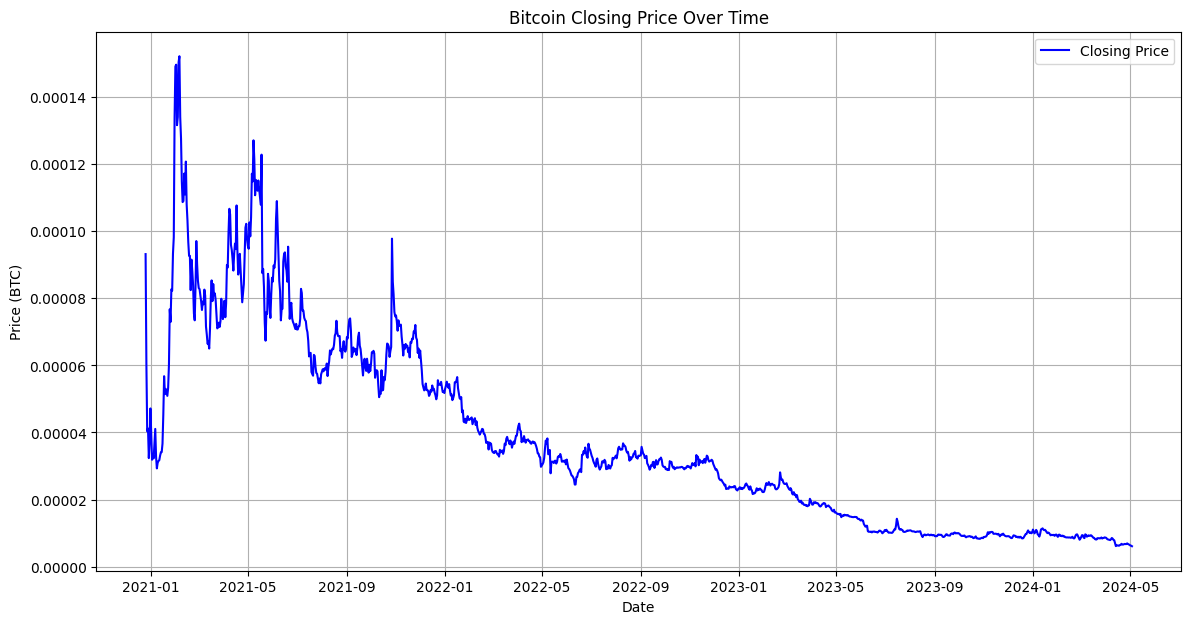

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Binance_1INCHBTC_d.csv', skiprows=1)

column_names = ['UNIX', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USDT', 'tradecount']
df.columns = column_names

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['close'], label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price (BTC)')
plt.title('Bitcoin Closing Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

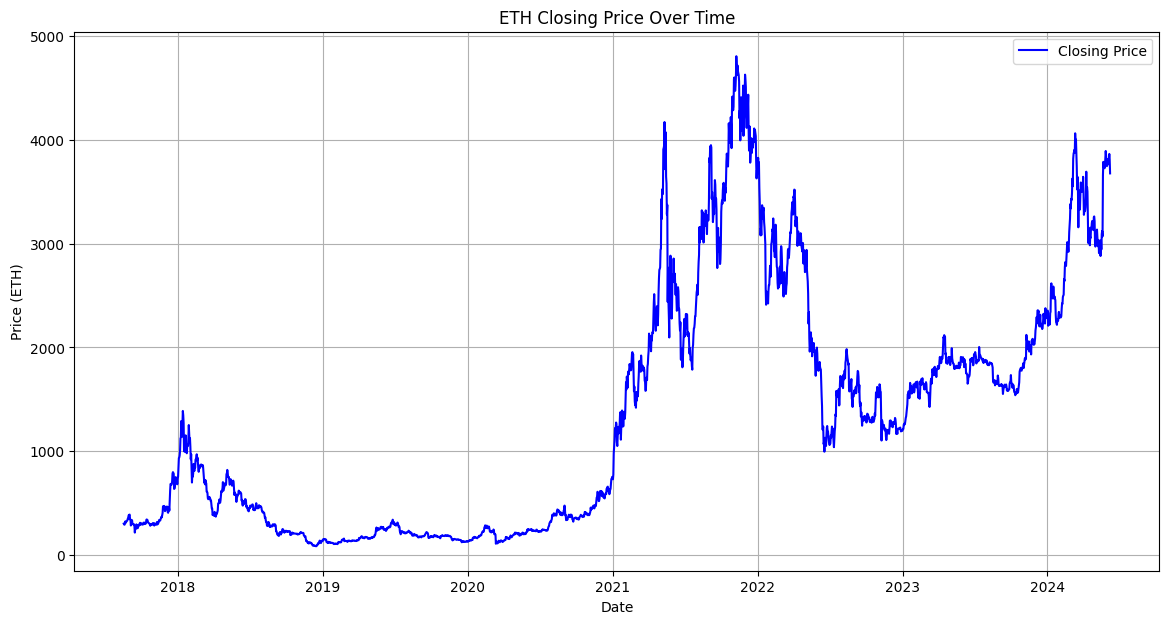

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/Binance_ETHUSDT_d.csv', skiprows=1)

column_names = ['UNIX', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume ETH', 'Volume USDT', 'tradecount']
df.columns = column_names

df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['close'], label='Closing Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price (ETH)')
plt.title('ETH Closing Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def truncate_text(text, max_length=512):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    return tokenizer.convert_tokens_to_string(tokens)

def get_bert_vector(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    pooled_output = torch.mean(last_hidden_state, dim=1)  # Example pooling strategy
    return pooled_output.squeeze().cpu().numpy()



Episode 1, Total Reward: 73.12, Avg Loss: 0.0607
Actions taken: {'buy': 766, 'sell': 883, 'hold': 838}
Final Balance: 9997.61

epsilon: 1.0
--------------------------------------
Episode 2, Total Reward: 49.42, Avg Loss: 0.0894
Actions taken: {'buy': 775, 'sell': 919, 'hold': 793}
Final Balance: 9995.42

epsilon: 0.9
--------------------------------------
Episode 3, Total Reward: -3.70, Avg Loss: 0.1093
Actions taken: {'buy': 776, 'sell': 978, 'hold': 733}
Final Balance: 9996.27

epsilon: 0.81
--------------------------------------
Episode 4, Total Reward: -14.33, Avg Loss: 0.1147
Actions taken: {'buy': 724, 'sell': 899, 'hold': 864}
Final Balance: 9993.11

epsilon: 0.7290000000000001
--------------------------------------
Episode 5, Total Reward: -25.49, Avg Loss: 0.1347
Actions taken: {'buy': 723, 'sell': 916, 'hold': 848}
Final Balance: 10009.12

epsilon: 0.6561000000000001
--------------------------------------
Episode 6, Total Reward: -96.23, Avg Loss: 0.1273
Actions taken: {'buy'

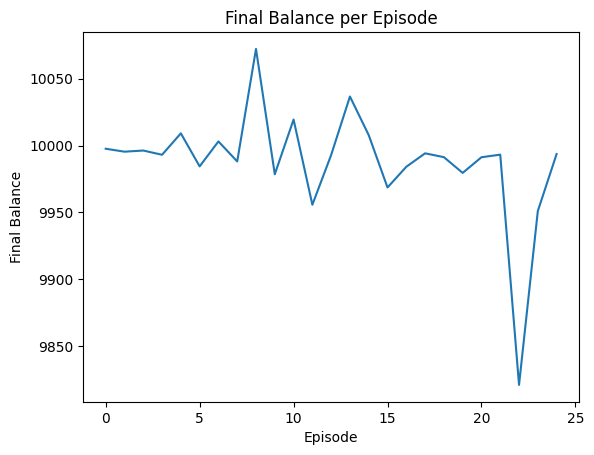

In [ ]:
class TradingEnv:
    def __init__(self, df, news_df, memory_size=1000):
        self.df = df
        self.news_df = news_df
        self.current_step = 0
        self.actions = ['buy', 'sell', 'hold']
        self.holding = False
        self.buy_price = 0.0
        self.balance = 10000
        self.stock_held = 0
        self.purchase_fee = 0.001
        self.sale_fee = 0.001
        self.replay_memory = deque(maxlen=memory_size)

    def reset(self):
        self.current_step = 0
        self.holding = False
        self.buy_price = 0.0
        self.balance = 10000
        self.stock_held = 0
        return self.get_state()

    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            done = True
            next_state = None
        else:
            self.current_step += 1
            done = False
            next_state = self.get_state()

        reward = self.calculate_reward(action)
        return next_state, reward, done

    def calculate_reward(self, action):
        current_price = self.df.iloc[self.current_step]['close']
        reward = 0
        if action == 'buy':
            if self.balance >= current_price * (1 + self.purchase_fee):
                self.stock_held += 1
                self.balance -= current_price * (1 + self.purchase_fee)
            else:
                reward = -1
        elif action == 'sell':
            if self.stock_held > 0:
                self.stock_held -= 1
                self.balance += current_price * (1 - self.sale_fee)
                reward = current_price - self.buy_price
            else:
                reward = -1
        elif action == 'hold':
            if self.holding:
                if current_price > self.buy_price:
                    reward = current_price - self.buy_price
                else:
                    reward = current_price - self.buy_price
                    if reward < 0:
                        reward *= 2

        return reward

    def get_state(self):
        price_data = self.df.iloc[self.current_step].to_dict()
        news_data = self.get_news(self.df.iloc[self.current_step]['date'])
        state_text = " ".join([f"{k}: {v}" for k, v in price_data.items()]) + " " + news_data

        # Truncate to 512 tokens
        encoded_input = tokenizer.encode(state_text, add_special_tokens=True, max_length=512, truncation=True)
        state_text_truncated = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoded_input))

        return state_text_truncated


    def get_news(self, date):
        news_on_date = self.news_df[self.news_df['date'].dt.date == date.date()]
        news_texts = news_on_date['text'].tolist()
        combined_news = " ".join(news_texts)
        return combined_news

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))

# Load price data
df = pd.read_csv('/content/Binance_ETHUSDT_d.csv', skiprows=1)
column_names = ['UNIX', 'date', 'symbol', 'open', 'high', 'low', 'close', 'Volume ETH', 'Volume USDT', 'tradecount']
df.columns = column_names
df['date'] = pd.to_datetime(df['date'])

numeric_columns = ['open', 'high', 'low', 'close', 'Volume ETH', 'Volume USDT']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df[numeric_columns] = df[numeric_columns] / df[numeric_columns].max()

# Load news data
news_df = pd.read_csv('/content/news.csv')
news_df['date'] = pd.to_datetime(news_df['date'])

env = TradingEnv(df, news_df)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 768  # Assuming BERT embedding size
action_dim = len(env.actions)

dqn = DQN(state_dim, action_dim).to(device)
optimizer = optim.Adam(dqn.parameters())

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

memory_size = 100
replay_memory = deque(maxlen=memory_size)
batch_size = 64

# params
alpha = 0.01  # Learning Rate
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.9  # Decay for exploration rate
min_epsilon = 0.05  # Minimum exploration rate

num_episodes = 25

def get_lowest_price(window):
    return window['low'].min()

final_balances = []  # Array to store final balances of each episode

for episode in range(num_episodes):
    state_text = env.reset()
    state_vector = get_bert_vector(state_text)
    done = False
    total_reward = 0
    episode_losses = []
    episode_action_counts = {'buy': 0, 'sell': 0, 'hold': 0}

    while not done:
        state_tensor = torch.tensor(state_vector, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = dqn(state_tensor)

        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(action_dim))
        else:
            action = torch.argmax(q_values).item()

        next_state_text, reward, done = env.step(env.actions[action])
        episode_action_counts[env.actions[action]] += 1

        if next_state_text is not None:
            next_state_vector = get_bert_vector(next_state_text)
        else:
            next_state_vector = state_vector

        replay_memory.append((state_vector, action, reward, next_state_vector, done))
    # Store successful transitions from the episode
    env.store_transition(state_vector, action, reward, next_state_vector, done)
        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

            state_batch_tensor = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
            action_batch_tensor = torch.tensor(action_batch, dtype=torch.long).to(device)
            reward_batch_tensor = torch.tensor(reward_batch, dtype=torch.float32).to(device)
            next_state_batch_tensor = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
            done_batch_tensor = torch.tensor(done_batch, dtype=torch.float32).to(device)

            q_values_batch = dqn(state_batch_tensor)
            next_q_values_batch = dqn(next_state_batch_tensor)

            target_batch = reward_batch_tensor + gamma * torch.max(next_q_values_batch, dim=1)[0] * (1 - done_batch_tensor)
            current_q_values = q_values_batch.gather(1, action_batch_tensor.unsqueeze(1)).squeeze(1)

            loss = nn.functional.mse_loss(current_q_values, target_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_losses.append(loss.item())

        state_vector = next_state_vector
        total_reward += reward

        if env.current_step % 5 == 0:
            recent_window = df.iloc[max(0, env.current_step-5):env.current_step+1]
            lowest_price = get_lowest_price(recent_window)
            if df.iloc[env.current_step]['low'] < lowest_price and env.actions[action] == 'buy':
                total_reward -= 1  # Penalize if a new lowest price is detected and agent buys at this price

    avg_loss = sum(episode_losses) / len(episode_losses) if episode_losses else 0
    final_balance = env.balance + env.stock_held * df.iloc[-1]['close']
    final_balances.append(final_balance)
    print(f'Episode {episode + 1}, Total Reward: {total_reward:.2f}, Avg Loss: {avg_loss:.4f}')
    print(f'Actions taken: {episode_action_counts}')
    print(f'Final Balance: {final_balance:.2f}\n')
    print(f'epsilon: {epsilon}')
    print("--------------------------------------")
    if epsilon > min_epsilon:
        epsilon = epsilon * epsilon_decay



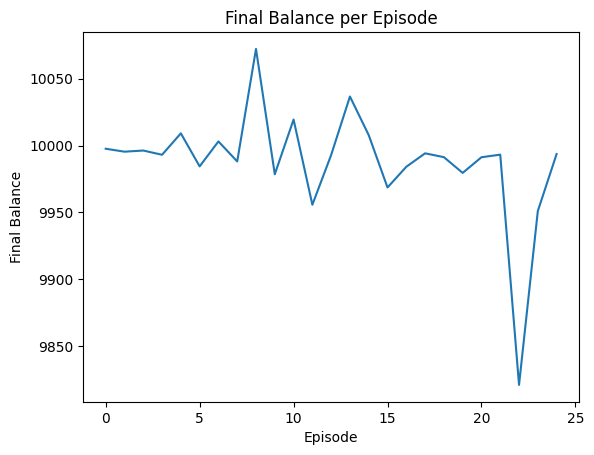

In [ ]:
plt.plot(final_balances)
plt.xlabel('Episode')
plt.ylabel('Final Balance')
plt.title('Final Balance per Episode')
plt.show()
